# Imports and Global Vars

In [ ]:
#@title Import all the packages { display-mode: "form" }
#@markdown <br><center><img src='https://upload.wikimedia.org/wikipedia/commons/5/53/Google_%22G%22_Logo.svg' height="50" alt="MEGA-logo"/></center>
#@markdown <center><h2>Import all the packages</h2></center><br>
#@markdown <h3>You need pillow to plot, and MatplotLib requires the latest version therefore you need to update it</h3><br/>

#@markdown #####If you need the Pillow, Don't panic the fist time the env is going to be stopped purposefully to update the Pillow package for the plots. 
#@markdown _*You need to re-run this cell manually if NEED_PILLOW = True._

NEED_PILLOW = True #@param ["True", "False"] {type:"raw"}
if NEED_PILLOW:
  import PIL
  if PIL.__version__ == '9.5.0':
    print('Pillow already updated to', PIL.__version__)
  else:
    print('Pillow need to be get updated from',PIL.__version__, "to 9.5.0")
    
    !pip install -q --upgrade Pillow
    exit()
    # import os
    # os.kill(os.getpid(), 9)

import torch
from torch.nn import CrossEntropyLoss, Module, Linear, Sequential, Conv3d, BatchNorm3d, ReLU, MaxPool3d, Dropout, Dropout3d
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor
from torch.optim import SGD, Adam
from tqdm import tqdm

from torchsummary import summary

import os
import random
from random import sample
from math import floor

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

print("Installing Open3d")
!pip install -q open3d
import open3d as o3d
print("open3d version:",o3d.__version__)

Pillow already updated to 9.5.0
Installing Open3d
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.5 MB/s eta 0:00:00
open3d version: 0.17.0


In [4]:
#@title Mounting Google Drive{ display-mode: "form" }
#@markdown <br><center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/1/12/Google_Drive_icon_%282020%29.svg/768px-Google_Drive_icon_%282020%29.svg.png' height="50" alt="MEGA-logo"/></center>
#@markdown <center><h2>Mount Google Drive</h2></center><br>
#@markdown <p>Mount Google Drive so we can point to the dataset</p><br>
from google.colab import drive
drive.mount('/content/drive')  #, force_remount=True

Mounted at /content/drive


In [5]:
#@title PARAMS & VARIABLES { display-mode: "form" }
#@markdown <center><h2>Set the parameters</h2></center><br>
#@markdown Set the seed to make more deterministic the task
SEED = 7 #@param {type:"number"}
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

### PARAMS & VARIABLES
ZIP_FILE = "Output_ROTATED_v7.zip" #@param ["Output_subset_v1.zip", "Output_ROTATED_v7.zip"]{type:"string"}
#@markdown <p>If you need to unzip "NNDL/Input/{zipFile}" put UNZIP to True</p><br>
# Eg. with Dataset for overfitting
UNZIP = False #@param ["True", "False"] {type:"raw"}
zipFilePath = f"/content/drive/MyDrive/NNDL/Input/{ZIP_FILE}"
if UNZIP:
  print(f"UNZIPPING: {zipFilePath}")
  !unzip -q -n "$zipFilePath" -d "/content/drive/MyDrive/NNDL/Input/"

INPUT_EXTENTION = ".ply" #@param {type:"string"}
INPUT_FOLDER = "NNDL/Input/Output_ROTATED_v7/" #@param ["NNDL/Input/Output_subset_v1/", "NNDL/Input/Output_ROTATED_v7/"]{type:"string"}
ROOT_FOLDER = os.path.dirname("/content/drive/MyDrive/"+INPUT_FOLDER)

#@markdown <pre>    NUM_WORKERS:  is set to os.cpu_count()
#@markdown     DEVICE:       is set to "CUDA" if runtime is set to GPU
#@markdown     BATCH_SIZE:   is set to 128 if DEVICE is set to "CUDA" otherwise is set to 64</pre>
NUM_WORKERS=os.cpu_count()
device = "cuda" if torch.cuda.is_available() else "cpu"

# BATCH SIZES:
# [32, 64] - CPU | [128, 256] - GPU for more boost
# Tried:
#   batch_size = 64 -> 2.1 GB GPU RAM & 1 Epock 25min & ram di sistema 5.1
#   batch_size = 512 -> 7.2 GB GPU RAM & 1 Epoch 2min & ram system 5.4
# 2.1:15 = 64:x -> 457.14 
#   batch_size = 1000 -> 11.0 GB GPU RAM (error if 2k says that pytorch occupies 6-8GB!)

BATCH_SIZE = 128 if device == "cuda" else 64 

print(f"device:{device}, BATCH_SIZE:{BATCH_SIZE}, NUM_WORKERS:{NUM_WORKERS}")

device:cuda, BATCH_SIZE:128, NUM_WORKERS:2


# 1. Dataset & Dataloader

In [6]:
#@title 1.1 Declaration { display-mode: "form" }

# 1.1.1 Folders and Classes
#@markdown <h2>1.1.1 Setting the folders </h2><br>
folders = [dir for dir in sorted(os.listdir(ROOT_FOLDER)) if os.path.isdir(os.path.join(ROOT_FOLDER,dir))]
classes = {folder:i for i, folder in enumerate(folders)};

print(f'folders: {folders}')
print(f'classes: {classes}')

# 1.1.2 Transformations
#@markdown <h2>1.1.2 Declaring the Transformations </h2><br>
class Cutout_3d:
    """
    Puts volume to 0 with a percentage 'percentage' in a cutout cube of shape 'cutout_size'

    params percentage,cutout_size
    """

    def __init__(self, percentage=0.2, cutout_size=(8,8,8)):
      self.percentage = percentage
      self.cutout_size = cutout_size

    def __call__(self, volume):
      if random.random() > (1-self.percentage):
        # starting point
        x = np.random.randint(0, 32 - self.cutout_size[0])
        y = np.random.randint(0, 32 - self.cutout_size[1])
        z = np.random.randint(0, 32 - self.cutout_size[2])
        cutout_cube = (x, y, z, self.cutout_size[0], self.cutout_size[1], self.cutout_size[2])
        volume[x:x+self.cutout_size[0], y:y+self.cutout_size[1], z:z+self.cutout_size[2]] = 0
      return volume

class PlyToNumpy:
    """Ges the VoxelGrid From a file and transform it to a np array"""

    def __call__(self, filename):
      if os.path.isfile(filename) and os.path.join(filename).endswith(INPUT_EXTENTION):
        voxelGrid = o3d.io.read_voxel_grid(filename, format='auto', print_progress=True)
        np_voxels = np.array(list(map(lambda x: x.grid_index, voxelGrid.get_voxels())))
        #print(len(np_voxels))

        np_voxelGrid = np.zeros((32, 32, 32))
        for j in range(len(np_voxels)):
          x = np_voxels[j][0]
          y = np_voxels[j][1]
          z = np_voxels[j][2]
          np_voxelGrid[x,y,x] = True #1
          #print(np_voxelGrid)
        
        #print(np_voxelGrid.shape)
        return np_voxelGrid
      else: raise('Not a valid PLY file, is the location correct?')

class ToDType:
    """Cast a tensor to a specific type"""
    def __init__(self, dtype=torch.float):
      self.dtype = dtype

    def __call__(self, tensor):
      return tensor.to(self.dtype)


class AddDummyChannel:
    """Reshape from (32,32,32) to (1,32,32,32)"""

    def __call__(self, tensor):
      return torch.reshape(tensor, (1,32,32,32))

#1.1.3 Voxel Grid Dataset
#@markdown <h2>1.1.3 Declaring Dataset </h2><br>
class VoxelGridDataset(Dataset):
    def __init__(self, dataset_folder, folder="train", transform=None):
        self.dataset_folder = dataset_folder
        folders = [dir for dir in sorted(os.listdir(dataset_folder)) if os.path.isdir(dataset_folder+"/"+dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform
        self.files = []
        for category in classes.keys():
          model_folder = os.path.join(dataset_folder,category,folder)
          for file in os.listdir(model_folder):
            if file.endswith(INPUT_EXTENTION):
              sample = {}
              sample['path'] = os.path.join(model_folder,file)
              sample['category'] = category
              self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        # TODO: IF VALID then don't do train transformation if usesing k-fold
        if self.transforms:
            voxelGrid = self.transforms(file)
        
        # voxelGrid = voxelGrid.to(torch.float) #uint8
        return voxelGrid

    def __onehotencoding__(self, category):
      cat = [0 for _ in range(10)]
      cat[self.classes[category]] = 1
      return torch.tensor(cat, dtype=torch.float) #uint8

    def __getitem__(self, idx):
        path = self.files[idx]['path']
        category = self.files[idx]['category']

        #print(path)
        voxelGrid = self.__preproc__(path)
        category =  self.__onehotencoding__(category) #cant use with crossentropy
        #category = classes[category]
        return voxelGrid, category

folders: ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
classes: {'bathtub': 0, 'bed': 1, 'chair': 2, 'desk': 3, 'dresser': 4, 'monitor': 5, 'night_stand': 6, 'sofa': 7, 'table': 8, 'toilet': 9}


In [7]:
#@title 1.2 Istantiating Dataset & Dataloader{ display-mode: "form" }
#@markdown <h4>1.2.1 Istantiating Dataset </h4>
TrainTransforms = Compose([
    PlyToNumpy(),
    # Cutout_3d(), # RandomErasing(),
    ToTensor(), # this converts numpy or image to torch tensor and normalizes it in 0, 1 
    ToDType(torch.float), #uint8
    AddDummyChannel(),
])

EvalTransforms = Compose([
    PlyToNumpy(),
    # Cutout_3d(), # RandomErasing(),
    ToTensor(), # this converts numpy or image to torch tensor and normalizes it in 0, 1 
    ToDType(torch.float), #uint8
    AddDummyChannel(),
])


train_folder =  VoxelGridDataset(ROOT_FOLDER, "train", TrainTransforms)
test_folder =  VoxelGridDataset(ROOT_FOLDER, "test",EvalTransforms)
#valid_dataset =  VoxelGridDataset(ROOT_FOLDER, "valid", ToTensor())

# 1.2.1 Test Datasets
#@markdown <h5>&nbsp &nbsp &nbsp &nbsp  1.2.1.1 Test Datasets</h5><br>
PRINT = False #@param ["True", "False"] {type:"raw"}
if PRINT:
  print('Train folder size: ', len(train_folder))
  print('Test folder size: ', len(test_folder))
  print('Number of classes: ', len(train_folder.classes))
  print('Sample VoxelGrid shape: ', train_folder[0][0].shape)
  print('Class: ',train_folder[99][1],"=",folders[train_folder[99][1].argmax()])
  #print('Class: ',folders[train_folder[9900][1]]) # without one hot encoding
  print('VoxelGrid: ', train_folder[99])


# 1.2.2 Dataloader
#@markdown <h4>1.2.2 Dataloader</h4>
#@markdown <pre> DOING as Simone Said, 
#@markdown       80/10/10 fixed otherwize we can try with k-fold on train 
#@markdown       but keep in mind to change the transformers accordingly </pre>
#@markdown &nbsp;&nbsp; &nbsp; Dataloader needs (BATCH_SIZE,NUM_WORKERS)
train_size = len(train_folder)
val_size = int(0.5 * len(test_folder))
test_size = len(test_folder) - val_size

if PRINT: print(train_size, val_size, test_size)

train_set = train_folder
valid_set, test_set = torch.utils.data.random_split(test_folder, [val_size, test_size])

# Istantianting the loaders
train_dataloader = DataLoader(train_set, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_dataloader = DataLoader(valid_set, min(BATCH_SIZE,len(valid_set)), shuffle=False, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_set, min(BATCH_SIZE,len(test_set)), shuffle=False, num_workers=NUM_WORKERS)

#@markdown &nbsp; &nbsp; 1.2.2.1 Check the distribution of the data [TODO]
def get_class_distribution(obj):
    count_dict = {
        "rating_3": 0,
        "rating_4": 0,
        "rating_5": 0,
        "rating_6": 0,
        "rating_7": 0,
        "rating_8": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['rating_3'] += 1
        elif i == 1: 
            count_dict['rating_4'] += 1
        elif i == 2: 
            count_dict['rating_5'] += 1
        elif i == 3: 
            count_dict['rating_6'] += 1
        elif i == 4: 
            count_dict['rating_7'] += 1  
        elif i == 5: 
            count_dict['rating_8'] += 1              
        else:
            print("Check classes.")
            
    return count_dict

count_dict = {folder:0 for i, folder in enumerate(folders)};
if PRINT:
  print(count_dict)

# 2. Model Definition

In [8]:
#@title 2. Model Definition { display-mode: "form" }
#@markdown <h3>2.0 Defining Utils</h3>

def calculateKernelSize(inKerDim,kernels,paddings,strides):
  if len(kernels) != len(paddings) != len(strides):
    return -1
  
  currentDim = inKerDim
  string = f'{currentDim}'
  for i in range(len(kernels)):
    k = kernels[i]
    p = paddings[i]
    s = strides[i]
    currentDim = floor((currentDim+2*p-k)/s+1)
    string += f' -> {currentDim}' 
  
  print(string)
  return currentDim

def calculateTensorDimention(kernelSize, kernelDim, lastLayerFiltersSize):
  return (kernelSize**kernelDim)*lastLayerFiltersSize

def getDimCNN(dim=32,kernel=3,stride=1,padding=0):
  """[(W−K+2P)/S]+1.
    dim is the input volume
    kernel is the Kernel size
    padding is the padding
    stride is the stride"""
  n = ((dim-kernel+2*padding)/stride)+1
  return n

PRINT = False #@param ["True", "False"] {type:"raw"}
if PRINT:
  print("getDimCNN(32,3,2,0):",getDimCNN(32,3,2,0))
  print("getDimCNN(64,3,1,0):",getDimCNN(64,3,1,0))
  inputDim = 32
  ## ORION ##
  filters = [32,64,128,256,   ] #out of the layer, last = pool2
  kernels = [3,  3,  3,  3,  2]
  strides = [2,  1,  1,  1,  2]
  paddings= [0,  0,  0,  0,  0]
  k = kernels #[elem for temp in zip(kernels,maxPoolKernels) for elem in temp]
  s = strides #[elem for temp in zip(strides,maxPoolStrides) for elem in temp]
  p = paddings #[elem for temp in zip(paddings,maxPoolPaddings) for elem in temp]

  print(k,s,p)
  ker = calculateKernelSize(inputDim,k,p,s)
  print("ker(ORION)=",ker)
  flattenVolume = calculateTensorDimention(ker,3,filters[-1])
  print("flattenVolume(ORION)=",flattenVolume)

  ## V3 ##
  filters = [16,32,64]
  kernels = [3,3,3]
  strides = [1,1,1] #32-->16 (if s=2)
  paddings = [1,1,1]
  dropoutRatios = [0.2,0.2,0.2]
  maxPoolKernels = [3,3,3]
  maxPoolStrides = [3,3,3] # H/3 -->
  maxPoolPaddings = [0,0,0]

  k = [elem for temp in zip(kernels,maxPoolKernels) for elem in temp]
  p = [elem for temp in zip(paddings,maxPoolPaddings) for elem in temp]
  s = [elem for temp in zip(strides,maxPoolStrides) for elem in temp]
  print(k,s,p)
  ker = calculateKernelSize(inputDim,k,p,s)
  print("ker(V3)=",ker)
  flattenVolume = calculateTensorDimention(ker,3,filters[-1])
  print("flattenVolume(V3)=",flattenVolume)

#@markdown ---
#@markdown <h3>2.1 Compiled Models:</h3>
#@markdown <h4>&nbsp; &nbsp;VGNet_v3</h4>

class VGNet_v3(Module):
  def __init__(self):
      super().__init__()

      # CONVs
      in_channels = 1
      voxelGridSize = 32
      voxelGridDim = 3 # 32x32x32

      filters = [32,64,128]
      kernels = [3,3,3]
      strides = [1,1,1] #32-->16 (if s=2)
      paddings = [1,1,1]
      dropoutRatios = [0.2,0.2,0.2]
      maxPoolKernels = [2,2,2]
      maxPoolStrides = [2,2,2] # H/3 -->
      maxPoolPaddings = [0,0,0]

      k = [elem for temp in zip(kernels,maxPoolKernels) for elem in temp]
      p = [elem for temp in zip(paddings,maxPoolPaddings) for elem in temp]
      s = [elem for temp in zip(strides,maxPoolStrides) for elem in temp]

      flattenVolume = calculateTensorDimention(calculateKernelSize(voxelGridSize,k,p,s),voxelGridDim,filters[-1])
      print(flattenVolume)

      # FCs
      fcOutput = [128,10]
      fcDropoutRatios = [0.4,0]

      self.network = Sequential(
          # OPT B: -> CONV/FC -> ReLu(or other activation) -> Dropout -> BatchNorm -> CONV/FC
          # Block 1 : > CONV -> BatchNorm -> ReLu -> Dropout ->
          Conv3d(in_channels, filters[0], kernel_size=3, stride=strides[0], padding=paddings[0]), #32-->16 (if s=2)
          BatchNorm3d(filters[0]),
          ReLU(),
          Dropout(dropoutRatios[0]),
          MaxPool3d(kernel_size=maxPoolKernels[0], stride=maxPoolStrides[0]), # H/3 -->

          # Block 2 : > CONV -> BatchNorm -> ReLu -> Dropout ->
          Conv3d(filters[0], filters[1], kernel_size=3, stride=strides[1], padding=paddings[1]), #32-->16 (if s=2)
          BatchNorm3d(filters[1]),
          ReLU(),
          Dropout(dropoutRatios[1]),
          MaxPool3d(kernel_size=maxPoolKernels[1], stride=maxPoolStrides[1]), # H/3

          # Block 3 : > CONV -> BatchNorm -> ReLu -> Dropout ->
          Conv3d(filters[1], filters[2], kernel_size=3, stride=strides[2], padding=paddings[2]), #32-->16 (if s=2)
          BatchNorm3d(filters[2]),
          ReLU(),
          Dropout(dropoutRatios[2]),
          MaxPool3d(kernel_size=maxPoolKernels[2], stride=maxPoolStrides[2]), # H/3

      )

      self.classification_layer = Sequential(
          # Block 5 : > FC -> ReLu -> Dropout ->
          Linear(flattenVolume,fcOutput[0]),
          ReLU(),
          Dropout(fcDropoutRatios[0]),

          # Block 6 : > FC -> ReLu -> Dropout ->
          Linear(fcOutput[0],fcOutput[1]), 
          #Dropout(fcDropoutRatios[1]),
      )
      
      self.apply(self._init_weights)

  def _init_weights(self, module):
      if isinstance(module, torch.nn.Linear):
          torch.nn.init.xavier_uniform_(module.weight)
          if module.bias is not None:
              module.bias.data.zero_()
      if isinstance(module, torch.nn.Conv3d):
          torch.nn.init.xavier_uniform_(module.weight)
          if module.bias is not None:
              module.bias.data.zero_()

  def forward(self, x):
      #print((x.shape))
      y = self.network(x).reshape((x.shape[0], -1))
      #print(y.shape)
      # ??? y = torch.flatten(y, 1) # flatten all dimensions except batch
      y = self.classification_layer(y)
      return y

#@markdown <h4>&nbsp; &nbsp;VGNetOrion_extended</h4>
class VGNetOrion_extended(Module):
    def __init__(self):
        super().__init__()

        # CONVs
        filters = [32,64,128,256]
        kernels = [3,3,3,3]
        strides = [2,1,1,1]
        paddings = [0,0,0,0]
        dropoutRatios = [0.2,0.3,0.4,0.6]

        # Getting Dimention of the tensor after flattening to give as input to fc
        k = kernels + [2]
        p = paddings + [0]
        s = strides + [2]
        flattenVolume = calculateTensorDimention(calculateKernelSize(32,k,p,s),3,filters[-1])
        print(flattenVolume)

        # FCs
        fcOutput = [128,10]
        fcDropoutRatios = [0.4,0]

        self.network = Sequential(
            # OPT B: -> CONV/FC -> ReLu(or other activation) -> Dropout -> BatchNorm -> CONV/FC
            # Block 1 : > CONV -> BatchNorm -> ReLu -> Dropout ->
            Conv3d(1, filters[0], kernel_size=kernels[0], stride=strides[0], padding=paddings[0]), 
            BatchNorm3d(filters[0]),
            ReLU(),
            Dropout(dropoutRatios[0]),

            # Block 2 : > CONV -> BatchNorm -> ReLu -> Dropout ->
            Conv3d(filters[0], filters[1], kernel_size=kernels[1], stride=strides[1], padding=paddings[1]), 
            BatchNorm3d(filters[1]),
            ReLU(),
            Dropout(dropoutRatios[1]),

            # Block 3 : > CONV -> BatchNorm -> ReLu -> Dropout ->
            Conv3d(filters[1], filters[2], kernel_size=kernels[2], stride=strides[2], padding=paddings[2]), 
            BatchNorm3d(filters[2]),
            ReLU(),
            Dropout(dropoutRatios[2]),

            # Block 4 : > CONV -> BatchNorm -> ReLu -> Dropout ->
            Conv3d(filters[2], filters[3], kernel_size=kernels[3], stride=strides[3], padding=paddings[3]), 
            BatchNorm3d(filters[3]),
            ReLU(),
            MaxPool3d(kernel_size=2, stride=2),
            Dropout(dropoutRatios[3]),
        )
        
        self.classification_layer = Sequential(
            # Block 5 : > FC -> ReLu -> Dropout ->
            Linear(flattenVolume,fcOutput[0]), 
            ReLU(),
            Dropout(fcDropoutRatios[0]),

            # Block 6 : > FC -> ReLu -> Dropout ->
            Linear(fcOutput[0],fcOutput[1]), 
            # Dropout(fcDropoutRatios[1]),
        )


        # self.classification_layer = Linear(flattenVolume, 10) #1124864 | 1728
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv3d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        #print("inputShape",x.shape)
        x = self.network(x) #.reshape((x.shape[0], -1))
        #print("afterCNN",x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print("afterFlattening",x.shape)
        out = self.classification_layer(x)
        #print("outputShape",x.shape)
        return out

if PRINT:
  # net2 = VGNet_v2()
  # summary(net2, (1,32,32,32))

  net2 = VGNet_v3()
  net2.to(device)
  summary(net2, (1,32,32,32))

  #temp = torch.rand(1,1,32,32,32).to(device)
  #temp = torch.reshape(train_set[0][0].to(device), (1, 1,32,32,32))
  #print(network(temp))

## 2.2 Old Models & ORIONs Models

In [ ]:
# Test dropout
m = Dropout(0.5)
m1 = Dropout(p=0)
m2 = Dropout(p=1)
i = np.array([[0,0,1.0,1.0,0,1.0],[0,0,1,1,0,1],[0,0,1,1,0,1],[0,0,1,1,0,1]])
print(i)
input = torch.from_numpy(i) #torch.randn(5, 3)
# input = input.to(float)

output = m(input)
output1 = m1(input)
output2 = m2(input)

print("--------------------------------------------------------")
print("Input\n",input)
print("--------------------------------------------------------")
print("Dropout[0.2]:\n",output)
print("--------------------------------------------------------")
print("In-Do[0.2]:\n",input-output)
print("--------------------------------------------------------")
print("Dropout[0]:\n",output1)
print("--------------------------------------------------------")
print("In-Do[0]:\n",input-output1)
print("--------------------------------------------------------")
print("In-Do[1]:\n",input-output2)
print("--------------------------------------------------------")
print("Dropout[1]:\n",output2)

[[0. 0. 1. 1. 0. 1.]
 [0. 0. 1. 1. 0. 1.]
 [0. 0. 1. 1. 0. 1.]
 [0. 0. 1. 1. 0. 1.]]
--------------------------------------------------------
Input
 tensor([[0., 0., 1., 1., 0., 1.],
        [0., 0., 1., 1., 0., 1.],
        [0., 0., 1., 1., 0., 1.],
        [0., 0., 1., 1., 0., 1.]], dtype=torch.float64)
--------------------------------------------------------
Dropout[0.2]:
 tensor([[0., 0., 0., 0., 0., 2.],
        [0., 0., 0., 0., 0., 2.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 2., 2., 0., 0.]], dtype=torch.float64)
--------------------------------------------------------
In-Do[0.2]:
 tensor([[ 0.,  0.,  1.,  1.,  0., -1.],
        [ 0.,  0.,  1.,  1.,  0., -1.],
        [ 0.,  0.,  1.,  1.,  0.,  1.],
        [ 0.,  0., -1., -1.,  0.,  1.]], dtype=torch.float64)
--------------------------------------------------------
Dropout[0]:
 tensor([[0., 0., 1., 1., 0., 1.],
        [0., 0., 1., 1., 0., 1.],
        [0., 0., 1., 1., 0., 1.],
        [0., 0., 1., 1., 0., 1.]], dtyp

### 2.2.1 Our Old Models

In [ ]:
class VGNet_v2(Module):
    def __init__(self):
        super().__init__()
        kernel_size = 3
        padding_val = kernel_size // 2
        padding_val = 0

        # CONVs
        filters = [16,32,64]
        kernels = [3,3,3]
        strides = [1,1,1]
        paddings = [1,1,1]
        dropoutRatios = [0.2,0.2,0.2]
        maxPoolKernels = [3,3,3]
        maxPoolStrides = [3,3,3]
        maxPoolPaddings = [0,0,0]

        k = [elem for temp in zip(kernels,maxPoolKernels) for elem in temp]
        p = [elem for temp in zip(paddings,maxPoolPaddings) for elem in temp]
        s = [elem for temp in zip(strides,maxPoolStrides) for elem in temp]

        flattenVolume = calculateTensorDimention(calculateKernelSize(32,k,p,s),3,filters[-1])
        print(flattenVolume)

        # FCs
        fcOutput = [64,10]
        fcDropoutRatios = [0.4,0]

        self.network = Sequential(
            # OPT B: -> CONV/FC -> ReLu(or other activation) -> Dropout -> BatchNorm -> CONV/FC
            # Block 1 : > CONV -> BatchNorm -> ReLu -> Dropout ->
            Conv3d(1, 16, kernel_size=3, stride=strides[0], padding=paddings[0]), #32-->16 (if s=2)
            BatchNorm3d(16),
            ReLU(),
            #Dropout(dropoutRatios[0]),
            MaxPool3d(kernel_size=maxPoolKernels[0], stride=maxPoolStrides[0]), # H/3 -->

            # Block 2 : > CONV -> BatchNorm -> ReLu -> Dropout ->
            Conv3d(16, 32, kernel_size=3, stride=strides[1], padding=paddings[1]), #32-->16 (if s=2)
            BatchNorm3d(32),
            ReLU(),
            #Dropout(dropoutRatios[1]),
            MaxPool3d(kernel_size=maxPoolKernels[1], stride=maxPoolStrides[1]), # H/3

            # Block 3 : > CONV -> BatchNorm -> ReLu -> Dropout ->
            Conv3d(32, 64, kernel_size=3, stride=strides[2], padding=paddings[2]), #32-->16 (if s=2)
            BatchNorm3d(64),
            ReLU(),
            #Dropout(dropoutRatios[2]),
            MaxPool3d(kernel_size=maxPoolKernels[2], stride=maxPoolStrides[2]), # H/3

        )

        self.classification_layer = Sequential(
            # Block 5 : > FC -> ReLu -> Dropout ->
            Linear(flattenVolume,fcOutput[0]),
            ReLU(),
            #Dropout(fcDropoutRatios[0]),

            # Block 6 : > FC -> ReLu -> Dropout ->
            Linear(fcOutput[0],fcOutput[1]), 
            #Dropout(fcDropoutRatios[1]),
        )
        
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv3d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        #print((x.shape))
        y = self.network(x).reshape((x.shape[0], -1))
        #print(y.shape)
        # ??? y = torch.flatten(y, 1) # flatten all dimensions except batch
        y = self.classification_layer(y)
        return y

In [ ]:
class VGNet_v2_old(Module):
    def __init__(self):
        super().__init__()
        kernel_size = 3
        padding_val = kernel_size // 2
        padding_val = 0

        # CONVs
        filters = [16,32,64]
        kernels = [3,3,3]
        strides = [1,1,1]
        paddings = [1,1,1]
        dropoutRatios = [0.2,0.2,0.2]
        maxPoolKernels = [3,3,3]
        maxPoolStrides = [3,3,3]
        maxPoolPaddings = [0,0,0]

        k = [elem for temp in zip(kernels,maxPoolKernels) for elem in temp]
        p = [elem for temp in zip(paddings,maxPoolPaddings) for elem in temp]
        s = [elem for temp in zip(strides,maxPoolStrides) for elem in temp]

        flattenVolume = calculateTensorDimention(calculateKernelSize(32,k,p,s),3,filters[-1])
        print(flattenVolume)

        # FCs
        fcOutput = [64,10]
        fcDropoutRatios = [0.4,0]

        self.network = Sequential(
            # OPT B: -> CONV/FC -> ReLu(or other activation) -> Dropout -> BatchNorm -> CONV/FC
            # Block 1 : > CONV -> BatchNorm -> ReLu -> Dropout ->
            Conv3d(1, 16, kernel_size=3, stride=strides[0], padding=paddings[0]), #32-->16 (if s=2)
            BatchNorm3d(16),
            ReLU(),
            Dropout(dropoutRatios[0]),
            MaxPool3d(kernel_size=maxPoolKernels[0], stride=maxPoolStrides[0]), # H/3 -->

            # Block 2 : > CONV -> BatchNorm -> ReLu -> Dropout ->
            Conv3d(16, 32, kernel_size=3, stride=strides[1], padding=paddings[1]), #32-->16 (if s=2)
            BatchNorm3d(32),
            ReLU(),
            Dropout(dropoutRatios[1]),
            MaxPool3d(kernel_size=maxPoolKernels[1], stride=maxPoolStrides[1]), # H/3

            # Block 3 : > CONV -> BatchNorm -> ReLu -> Dropout ->
            Conv3d(32, 64, kernel_size=3, stride=strides[2], padding=paddings[2]), #32-->16 (if s=2)
            BatchNorm3d(64),
            ReLU(),
            Dropout(dropoutRatios[2]),
            MaxPool3d(kernel_size=maxPoolKernels[2], stride=maxPoolStrides[2]), # H/3

        )

        self.classification_layer = Sequential(
            # Block 5 : > FC -> ReLu -> Dropout ->
            Linear(flattenVolume,fcOutput[0]),
            ReLU(),
            Dropout(fcDropoutRatios[0]),

            # Block 6 : > FC -> ReLu -> Dropout ->
            Linear(fcOutput[0],fcOutput[1]), 
            #Dropout(fcDropoutRatios[1]),
        )
        
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv3d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        #print((x.shape))
        y = self.network(x).reshape((x.shape[0], -1))
        #print(y.shape)
        # ??? y = torch.flatten(y, 1) # flatten all dimensions except batch
        y = self.classification_layer(y)
        return y

In [ ]:
class VGNet_v1(Module):
    def __init__(self):
        super().__init__()
        kernel_size = 3
        padding_val = kernel_size // 2

        self.network = Sequential(
            # OPT B: -> CONV/FC -> ReLu(or other activation) -> Dropout -> BatchNorm -> CONV/FC
            # Block 1 : > CONV -> BatchNorm -> ReLu -> Dropout ->
            Conv3d(1, 16, kernel_size=3, stride=1, padding=padding_val), #32-->16 (if s=2)
            BatchNorm3d(16),
            ReLU(),
            Dropout(0.2),
            MaxPool3d(kernel_size=3, stride=2), # H/3 -->

            # Block 2 : > CONV -> BatchNorm -> ReLu -> Dropout ->
            Conv3d(16, 32, kernel_size=3, stride=1, padding=padding_val), #32-->16 (if s=2)
            BatchNorm3d(32),
            ReLU(),
            Dropout(0.2),
            MaxPool3d(kernel_size=3, stride=2), # H/3

            # Block 3 : > CONV -> BatchNorm -> ReLu -> Dropout ->
            Conv3d(32, 64, kernel_size=3, stride=2, padding=padding_val), #32-->16 (if s=2)
            BatchNorm3d(64),
            ReLU(),
            Dropout(0.2),
            MaxPool3d(kernel_size=3, stride=2), # H/3
        )
        self.classification_layer = Linear(64, 10) #1124864 | 1728
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv3d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        #print((x.shape))
        y = self.network(x).reshape((x.shape[0], -1))
        #print(y.shape)
        # ??? y = torch.flatten(y, 1) # flatten all dimensions except batch
        y = self.classification_layer(y)
        return y

#### 2.2.1.1 Testing Model

In [ ]:
print("########################## NET1")
net1 = VGNet_v1()
net1.to(device)
summary(net1, (1,32,32,32))

print("########################## NET2")
net2 = VGNet_v2()
net2.to(device)
summary(net2, (1,32,32,32))

#temp = torch.rand(1,1,32,32,32).to(device)
#temp = torch.reshape(train_set[0][0].to(device), (1, 1,32,32,32))
#print(network(temp))

########################## NET1
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 32, 32, 32]             448
       BatchNorm3d-2       [-1, 16, 32, 32, 32]              32
              ReLU-3       [-1, 16, 32, 32, 32]               0
           Dropout-4       [-1, 16, 32, 32, 32]               0
         MaxPool3d-5       [-1, 16, 15, 15, 15]               0
            Conv3d-6       [-1, 32, 15, 15, 15]          13,856
       BatchNorm3d-7       [-1, 32, 15, 15, 15]              64
              ReLU-8       [-1, 32, 15, 15, 15]               0
           Dropout-9       [-1, 32, 15, 15, 15]               0
        MaxPool3d-10          [-1, 32, 7, 7, 7]               0
           Conv3d-11          [-1, 64, 4, 4, 4]          55,360
      BatchNorm3d-12          [-1, 64, 4, 4, 4]             128
             ReLU-13          [-1, 64, 4, 4, 4]               0
       

### 2.2.2 Orion Models

In [ ]:
class VGNetOrion_extended(Module):
    def __init__(self):
        super().__init__()

        # CONVs
        filters = [32,64,128,256]
        kernels = [3,3,3,3]
        strides = [2,1,1,1]
        paddings = [0,0,0,0]
        dropoutRatios = [0.2,0.3,0.4,0.6]

        # Getting Dimention of the tensor after flattening to give as input to fc
        k = kernels + [2]
        p = paddings + [0]
        s = strides + [2]
        flattenVolume = calculateTensorDimention(calculateKernelSize(32,k,p,s),3,filters[-1])
        print(flattenVolume)

        # FCs
        fcOutput = [128,10]
        fcDropoutRatios = [0.4,0]

        self.network = Sequential(
            # OPT B: -> CONV/FC -> ReLu(or other activation) -> Dropout -> BatchNorm -> CONV/FC
            # Block 1 : > CONV -> BatchNorm -> ReLu -> Dropout ->
            Conv3d(1, filters[0], kernel_size=kernels[0], stride=strides[0], padding=paddings[0]), 
            BatchNorm3d(filters[0]),
            ReLU(),
            Dropout(dropoutRatios[0]),

            # Block 2 : > CONV -> BatchNorm -> ReLu -> Dropout ->
            Conv3d(filters[0], filters[1], kernel_size=kernels[1], stride=strides[1], padding=paddings[1]), 
            BatchNorm3d(filters[1]),
            ReLU(),
            Dropout(dropoutRatios[1]),

            # Block 3 : > CONV -> BatchNorm -> ReLu -> Dropout ->
            Conv3d(filters[1], filters[2], kernel_size=kernels[2], stride=strides[2], padding=paddings[2]), 
            BatchNorm3d(filters[2]),
            ReLU(),
            Dropout(dropoutRatios[2]),

            # Block 4 : > CONV -> BatchNorm -> ReLu -> Dropout ->
            Conv3d(filters[2], filters[3], kernel_size=kernels[3], stride=strides[3], padding=paddings[3]), 
            BatchNorm3d(filters[3]),
            ReLU(),
            MaxPool3d(kernel_size=2, stride=2),
            Dropout(dropoutRatios[3]),
        )
        
        self.classification_layer = Sequential(
            # Block 5 : > FC -> ReLu -> Dropout ->
            Linear(flattenVolume,fcOutput[0]), 
            ReLU(),
            Dropout(fcDropoutRatios[0]),

            # Block 6 : > FC -> ReLu -> Dropout ->
            Linear(fcOutput[0],fcOutput[1]), 
            # Dropout(fcDropoutRatios[1]),
        )


        # self.classification_layer = Linear(flattenVolume, 10) #1124864 | 1728
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv3d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        #print("inputShape",x.shape)
        x = self.network(x) #.reshape((x.shape[0], -1))
        #print("afterCNN",x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print("afterFlattening",x.shape)
        out = self.classification_layer(x)
        #print("outputShape",x.shape)
        return out

In [ ]:
class VGNetOrion(Module):
    def __init__(self):
        super().__init__()

        # CONVs
        filters = [32,32]
        kernels = [5,3]
        strides = [2,1]
        paddings = [0,0]
        dropoutRatios = [0.2,0.3]

        # Getting Dimention of the tensor after flattening to give as input to fc
        k = kernels + [2]
        p = paddings + [0]
        s = strides + [2]
        flattenVolume = calculateTensorDimention(calculateKernelSize(32,k,p,s),3,filters[-1])
        print(flattenVolume)

        # FCs
        fcOutput = [128,10]
        fcDropoutRatios = [0.4,0]

        self.network = Sequential(
            # OPT B: -> CONV/FC -> ReLu(or other activation) -> Dropout -> BatchNorm -> CONV/FC
            # Block 1 : > CONV -> BatchNorm -> ReLu -> Dropout ->
            Conv3d(1, filters[0], kernel_size=kernels[0], stride=strides[0], padding=paddings[0]), 
            BatchNorm3d(filters[0]),
            ReLU(),
            Dropout(dropoutRatios[0]),

            # Block 2 : > CONV -> BatchNorm -> ReLu -> Dropout ->
            Conv3d(filters[0], filters[1], kernel_size=kernels[1], stride=strides[1], padding=paddings[1]), 
            BatchNorm3d(filters[1]),
            ReLU(),
            MaxPool3d(kernel_size=2, stride=2),
            Dropout(dropoutRatios[1]),
        )
        
        self.classification_layer = Sequential(
            # Block 5 : > FC -> ReLu -> Dropout ->
            Linear(flattenVolume,fcOutput[0]), 
            ReLU(),
            Dropout(fcDropoutRatios[0]),

            # Block 6 : > FC -> ReLu -> Dropout ->
            Linear(fcOutput[0],fcOutput[1]), 
            # Dropout(fcDropoutRatios[1]),
        )


        # self.classification_layer = Linear(flattenVolume, 10) #1124864 | 1728
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv3d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        print("inputShape_2",x.shape)
        x = self.network(x) #.reshape((x.shape[0], -1))
        print("afterCNN_2",x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        print("afterFlattening_2",x.shape)
        out = self.classification_layer(x)
        print("outputShape_2",x.shape)
        return out

#### 2.2.2.1 Testing Orion Models

In [ ]:
### Testing our network
from torchsummary import summary
print("########################## NET1")
net1 = VGNetOrion()
net1.to(device)
summary(net1, (1,32,32,32))
print("\n\n ########################## NET2")
net2 = VGNetOrion_extended()
net2.to(device)
summary(net2, (1,32,32,32))

#temp = torch.rand(1,1,32,32,32).to(device)
#temp = torch.reshape(train_set[0][0].to(device), (1, 1,32,32,32))
#print(network(temp))

########################## NET1
32 -> 14 -> 12 -> 6
6912
inputShape_2 torch.Size([2, 1, 32, 32, 32])
afterCNN_2 torch.Size([2, 32, 6, 6, 6])
afterFlattening_2 torch.Size([2, 6912])
outputShape_2 torch.Size([2, 6912])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 14, 14, 14]           4,032
       BatchNorm3d-2       [-1, 32, 14, 14, 14]              64
              ReLU-3       [-1, 32, 14, 14, 14]               0
           Dropout-4       [-1, 32, 14, 14, 14]               0
            Conv3d-5       [-1, 32, 12, 12, 12]          27,680
       BatchNorm3d-6       [-1, 32, 12, 12, 12]              64
              ReLU-7       [-1, 32, 12, 12, 12]               0
         MaxPool3d-8          [-1, 32, 6, 6, 6]               0
           Dropout-9          [-1, 32, 6, 6, 6]               0
           Linear-10                  [-1, 128]         884,864
             R

# 3. Training 

In [ ]:
#@title TODO utils
def showPlot(train_losses,val_losses):
  print(train_losses,val_losses)
  plt.figure(figsize=(10,5))
  plt.title("Training and Validation Loss")
  plt.plot(val_losses,label="val")
  plt.plot(train_losses,label="train")
  plt.xlabel("iterations")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    return acc

## 3.1 Declaration Model

In [9]:
import os.path
from os import path

#@title PARAMS & VARIABLES for training { display-mode: "form" }
#@markdown <center><h2>Set the parameters</h2></center><br>
#@markdown Select and run

MODEL = "VGNet_v3" #@param ["VGNetOrion_extended", "VGNet_v3"]{type:"string"}

model = None
if MODEL == 'VGNetOrion_extended':
  model = VGNetOrion_extended()
else:
  model = VGNet_v3()

model.to(device)

OPTIMIZER = "Adam" # @param ["Adam", "SGD"]{type:"string"}
LEARNING_RATE = 1e-3 # @param ["1e-2","1e-3","1e-4"]{type:"raw"}
#@markdown <pre>Normally LR would be:
#@markdown            <b>0.001</b> for ADAM 
#@markdown       and <b>0.0001</b> with SGD</pre>

opt = Adam(model.parameters(), lr=LEARNING_RATE) #0.001
if OPTIMIZER == "SGD":
  opt = SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9) #0.0004

loss_fn = CrossEntropyLoss()
best_val = np.inf
best_train_loss = np.inf
#@markdown ---
#@markdown If the Folders doesnt exits they will be created dependin on the selected model
#@markdown <pre>     /content/drive/MyDrive/NNDL/Models/{Orion|Our}</pre>

DRIVE_ROOT = "/content/drive/MyDrive/"
if "Orion".casefold() in MODEL.casefold():
  MODEL_DESTINATION_FOLDER = "NNDL/Model/Orion" 
else:
  MODEL_DESTINATION_FOLDER = "NNDL/Model/Our" 

modelFolder = DRIVE_ROOT+MODEL_DESTINATION_FOLDER+"/"

os.chdir(DRIVE_ROOT)
for folder in MODEL_DESTINATION_FOLDER.split("/"):
  if path.exists(folder) == False:
    os.mkdir(folder)
    print("Making Dir:", folder)
  os.chdir(folder)
  # !pwd
  # !ls

MODEL_NAME_SUFFIX = "" # @param {type:"string"}
modelName = MODEL.casefold()+"_"+OPTIMIZER.casefold()+"_"+'{:.0e}'.format(LEARNING_RATE)
def isNotBlank(s):
    return bool(s and not s.isspace())

if isNotBlank(MODEL_NAME_SUFFIX):
  modelName +="_"+MODEL_NAME_SUFFIX
modelFileName = modelFolder+modelName+".pt" 
print("Model will be saved as (AbsolutePath):\n\t", modelFileName)

32 -> 32 -> 16 -> 16 -> 8 -> 8 -> 4
8192
Model will be saved as (AbsolutePath):
	 /content/drive/MyDrive/NNDL/Model/Our/vgnet_v3_adam_1e-03.pt


In [10]:
#@title Reload the model from the disk
RELOAD = True #@param ["True", "False"] {type:"raw"}
if RELOAD:
  name = modelFileName
  # name = "/content/drive/MyDrive/NNDL/Model/Our/vgnet_v3_adam_1e-03.pt"
  print("Reloading model: ", name)
  model.load_state_dict(torch.load(name)) #,map_location=torch.device('cpu'))) #))
  model.to(device)

Reloading model:  /content/drive/MyDrive/NNDL/Model/Our/vgnet_v3_adam_1e-03.pt


## 3.2 Training

In [ ]:
#@title Train
%%time

epochs=50 #@param {type:"number"}
old = 600 #@param {type:"number"}
# train_losses, val_losses= [],[] # np.array([]), np.array([])

for epoch in range(epochs):
    # TRAINING
    model.train()
    print(f"Epoch: {epoch+1+old}")
    iterator = tqdm(train_dataloader)
    cur_batch = 0
    for batch_x, batch_y in iterator:
        train_loss = 0
        cur_batch += 1
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        y_pred = model(batch_x)

        loss = loss_fn(y_pred, batch_y)

        opt.zero_grad()
        loss.backward()
        opt.step()
        iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")
        # train_losses.extend(loss.detach().cpu().numpy())
        # np.append(train_losses,loss.detach().cpu().numpy())
        
        train_loss += loss.detach().cpu().numpy()
    train_loss /= cur_batch
    # VALIDATION
    model.eval()
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x, batch_y in tqdm(valid_dataloader):#valid_dataloader
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            y_pred = model(batch_x)

            # _, y_pred_indices = torch.max(y_pred, dim = 1)

            predictions.append(y_pred)
            true.append(batch_y)

        predictions = torch.cat(predictions, axis=0)
        true = torch.cat(true, axis=0)
        val_loss = loss_fn(predictions, true)
        val_acc = (torch.sigmoid(predictions).round() == true).float().mean()
        print(f"loss: {val_loss}, accuracy: {val_acc}")
        # val_losses.extend(val_loss.detach().cpu().numpy())
        # np.append(val_losses,val_loss.detach().cpu().numpy())

    # showPlot(train_losses,val_losses)m
    
    if val_loss < best_val:
        print("Saved Model")
        torch.save(model.state_dict(), modelFileName)
        best_val = val_loss  

    # if train_loss < best_val:
    #     print("Saved Model")
    #     torch.save(model.state_dict(), modelFileName)
    #     best_val = train_loss 

#@markdown If you want to save the model after the end the epocs. Will be saved in the same path as {model_name}_{old+epochs}.pt
SNAPSHOT = False #@param ["True", "False"] {type:"raw"}   
if SNAPSHOT:
  n = modelFolder+modelName+"_"+str(old+epochs)+".pt"
  #n = "/content/drive/MyDrive/NNDL/Model/Our/"+"vgnet_v3_adam_1e-03_2000"+".pt" 
  torch.save(model.state_dict(), n)
  print(f"\nSnapshot saved @ {n}")

Epoch: 601


Train loss: 1.2848212718963623:  46%|████▌     | 36/79 [30:20<29:40, 41.40s/it]

In [11]:
#@title Save
SAVE_AGAIN = False #@param ["True", "False"] {type:"raw"}   
if SAVE_AGAIN:
  n = modelFolder+modelName+"_"+str(old+epochs)+".pt" # n = "/content/drive/MyDrive/NNDL/Model/Our/"+"vgnet_v3_adam_1e-03_200"+".pt" 
  torch.save(model.state_dict(), n)
  print(f"Snapshot saved again @ {n}")

## 3.3 Evaluation

In [12]:
#@title Def Function
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, roc_auc_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_network(dataloader, model, data_split):
    model.eval()
    with torch.no_grad():
        y_pred = []
        y_true = []
        for batch_x, batch_y in tqdm(dataloader):
            y_true.extend(batch_y.numpy())

            batch_x = batch_x.to(device)
            output = model(batch_x)
            _, y_pred_indices = torch.max(output, 1)
            y_pred.extend(y_pred_indices.detach().cpu().numpy())

            # here
            # idx = 3
            # print("\n",batch_y[idx])
            # print(output[idx])
            # print(y_pred_indices[idx])

        return y_pred, y_true

        # cf_matrix = confusion_matrix(y_true, y_pred)

        # confusion_matrix_df = pd.DataFrame(cf_matrix,columns=folders, index=folders)
        # print(confusion_matrix_df)
        # sns.heatmap(confusion_matrix_df, annot=True)

        # plt.figure(figsize=(8, 6))
        # # Create heatmap
        # sns.heatmap(confusion_matrix_df, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
        
        # plt.title("Confusion Matrix"), plt.tight_layout()
        
        # plt.ylabel("True Class"), 
        # plt.xlabel("Predicted Class")
        # plt.show()

        # print(classification_report(true, predictions))

### Testing

In [ ]:
# Example of target with class indices
l = CrossEntropyLoss()
i = torch.randn(3, 5, requires_grad=True)
t = torch.empty(3, dtype=torch.long).random_(5)
o = l(i, t)

print(i)
print(t)
print(o)
o.backward()

tensor([[ 1.4461,  0.1719,  0.6503, -0.8895, -0.9205],
        [-0.5506,  1.5064, -0.6918, -0.0603, -0.4062],
        [ 0.5554, -0.2472,  1.3418, -2.1602,  0.5739]], requires_grad=True)
tensor([0, 3, 3])
tensor(2.3187, grad_fn=<NllLossBackward0>)


In [ ]:
i = torch.from_numpy(np.array([[-0.2780,  0.1333,  0.6315, -0.2018, -0.4244, -0.0448, -0.5552,  0.0548,
        -0.3131,  0.0555]]))
t = torch.from_numpy(np.array([2]))
o = l(i, t)

print(i)
print(t)
print(o)

tensor([[-0.2780,  0.1333,  0.6315, -0.2018, -0.4244, -0.0448, -0.5552,  0.0548,
         -0.3131,  0.0555]], dtype=torch.float64)
tensor([2])
tensor(1.6330, dtype=torch.float64)


In [ ]:
evaluate_network(valid_dataloader, model, "Validation Dataset")

In [ ]:
a = np.array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float)
print(a.argmax())

2


### Reload & Evaluate

In [ ]:
#@title Reloading the last saved model
# Evaluating saved model, need to reload otherwise you will evaluate on the last updates done on the model while training
model_eval = None
if MODEL == 'VGNetOrion_extended':
  model_eval = VGNetOrion_extended()
else:
  model_eval = VGNet_v3()

#modelFileName = "/content/drive/MyDrive/NNDL/model_3_sgdm_1e-3_overfitting_26-03.pt"
model_eval.load_state_dict(torch.load(modelFileName)) #,map_location=torch.device('cpu'))) #))
model_eval.to(device)

100%|██████████| 11/11 [08:44<00:00, 47.70s/it]


y_pred: [4, 4, 9, 4, 2, 4, 3, 5, 1, 8, 1, 6, 5, 4, 3, 1, 8, 6, 2, 8, 2, 2, 8, 6, 4, 2, 6, 9, 5, 5, 9, 1, 9, 8, 1, 7, 9, 6, 3, 6, 8, 6, 3, 6, 8, 0, 6, 6, 8, 4, 9, 8, 8, 8, 8, 4, 7, 1, 8, 1, 1, 5, 5, 5, 8, 4, 5, 1, 6, 8, 8, 8, 1, 1, 5, 8, 8, 2, 1, 6, 9, 4, 8, 1, 8, 8, 1, 1, 1, 8, 8, 6, 0, 3, 8, 8, 9, 4, 6, 2, 2, 1, 4, 3, 2, 3, 0, 8, 1, 1, 5, 6, 9, 2, 6, 4, 1, 1, 8, 8, 8, 4, 5, 5, 4, 8, 8, 4, 1, 4, 6, 6, 1, 8, 8, 5, 7, 8, 9, 4, 9, 8, 9, 8, 0, 1, 8, 8, 5, 1, 8, 9, 6, 3, 1, 0, 0, 2, 0, 7, 4, 9, 1, 8, 3, 6, 6, 1, 1, 8, 2, 3, 9, 5, 1, 6, 6, 9, 4, 6, 4, 1, 8, 1, 2, 5, 4, 5, 9, 0, 7, 3, 8, 8, 4, 5, 2, 1, 2, 9, 1, 5, 9, 8, 1, 7, 6, 2, 6, 8, 6, 3, 5, 8, 1, 4, 9, 8, 4, 8, 9, 1, 9, 3, 5, 1, 2, 2, 7, 8, 8, 9, 6, 6, 8, 3, 1, 1, 7, 6, 7, 8, 8, 3, 3, 8, 2, 1, 8, 1, 1, 4, 8, 1, 8, 0, 8, 0, 9, 8, 9, 6, 1, 6, 4, 4, 1, 2, 8, 8, 7, 4, 8, 5, 8, 7, 9, 0, 2, 8, 9, 1, 2, 8, 9, 5, 5, 9, 8, 4, 3, 7, 1, 6, 8, 8, 5, 3, 2, 6, 8, 9, 1, 7, 1, 1, 1, 4, 4, 5, 4, 0, 8, 3, 9, 7, 1, 1, 1, 1, 4, 9, 2, 1, 3, 9, 4, 1, 4, 3, 6

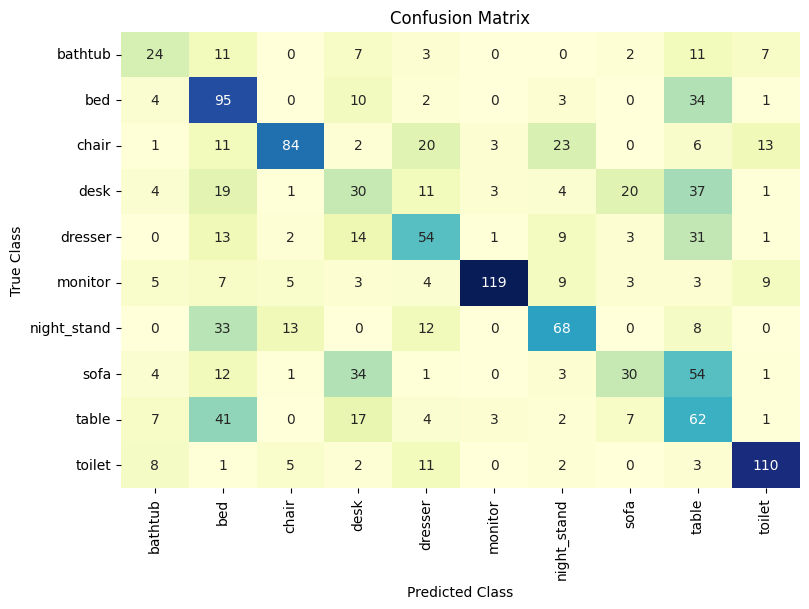

In [14]:
#@title Evaluate
#@markdown Dataset to evaluate:
dataset = valid_dataloader #@param ["valid_dataloader", "test_dataloader","train_dataloader"] {type:"raw"}
y_pred, y_true = evaluate_network(dataset, model_eval, "Validation Dataset") #train_dataloader
y_true = [a.argmax() for a in y_true]

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print(f"Report at epoc{str(old+epochs)} :\n",classification_report(y_true, y_pred))

# PLOT:
cf_matrix = confusion_matrix(y_true, y_pred)
confusion_matrix_df = pd.DataFrame(cf_matrix,columns=folders, index=folders)

plt.figure(figsize=(8, 6))
# Create heatmap
sns.heatmap(confusion_matrix_df, annot=True, cbar=None,cmap="YlGnBu",fmt="d")

plt.title("Confusion Matrix"), plt.tight_layout()

plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()



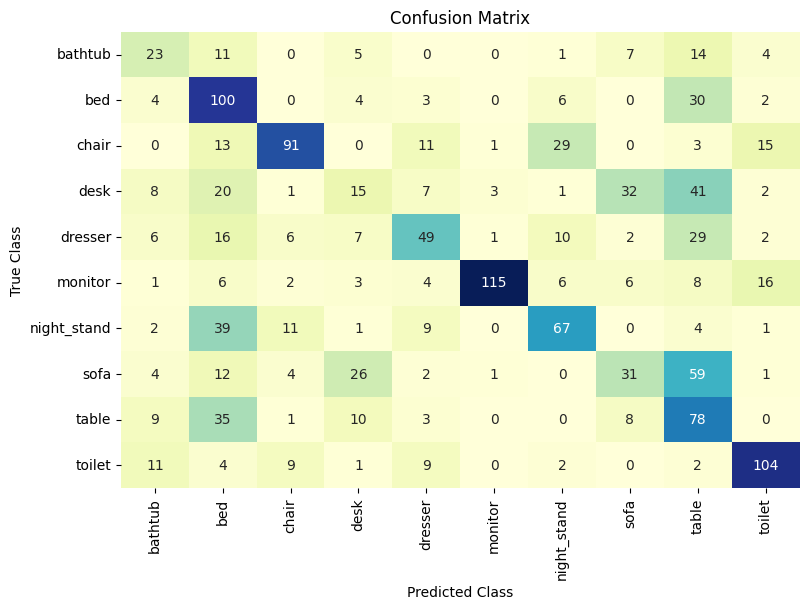

In [ ]:
#@title Plot
cf_matrix = confusion_matrix(y_true, y_pred)
confusion_matrix_df = pd.DataFrame(cf_matrix,columns=folders, index=folders)

plt.figure(figsize=(8, 6))
# Create heatmap
sns.heatmap(confusion_matrix_df, annot=True, cbar=None,cmap="YlGnBu",fmt="d")

plt.title("Confusion Matrix"), plt.tight_layout()

plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()